In [1]:
#Calculating the escape fraction Epsilon as a function of Black Hole Mass
import matplotlib
#matplotlib.use('Agg')
import yt
import numpy as np
import sys
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import glob
from yt.utilities.physical_constants import mh, mp, me, G, kboltz, pi
from math import pi
from yt.units.yt_array import YTQuantity, YTArray
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 20})


In [2]:
def BondiRadius(M_BH, cs, v):
    R = G * M_BH / (cs*cs + v*v)
    return R


In [3]:
#Merger Rate of Heavy Seeds
#
R_0 = YTQuantity(200, 'pc') #Setting the radius of the inital black hole radius from centre
Num_HeavySeeds = 100             #masses > 1000 Msolar

#Just test with this seed mass
M_BH = YTQuantity(1e5, 'msun')   #Peak heavy seed mass spectrum 10^4
#N_tot = YTQuantity(1000, 'kpc**-3') #to induce mergers we need a large density
#GalaxySize = YTQuantity(1, 'kpc')
#GalaxyVolume = 4 * np.pi * np.power(GalaxySize, 3.0)/3.0

#The background density is the total density (DM + gas + stars)
#For LeoI the total mass inside 1 kpc ~ 7 x 10^8 Msolar (i.e. pretty dense) so the density is 
#approximately 2e8 Msun/kpc^3. However, dynamical friction isn't as effective as this and 
#this has been realised when observing systems like Fornax etc. 
#Changing this value has a big impact on the dynamical friction timescale however and is the 
#single biggest driver. For LeoI the below value is probably ok I tink?

background_density = YTQuantity(4e6, 'Msun/kpc**3')
Temp = YTQuantity(10000, 'K')    #can vary (lower) this but 10000 K is reasonable
Gamma = 5.0/3.0
Mu = 1.22

tau_hubble = YTQuantity(13.8, 'Gyr') #age of Universe
f = 1e-4                          # fraction of volume filled with dense gas
soundspeed2 = Gamma*kboltz*Temp/(Mu*mh)
soundspeed = YTQuantity(np.sqrt(soundspeed2).d, 'cm/s')
cs = soundspeed
v_bh = cs/2.0
R_bondi = BondiRadius(M_BH.in_units('g'), cs, v_bh)

def MergerRate(M_BH, v_bh, cs, N_tot):
    sigma = BondiRadius(M_BH.in_units('g'), cs, v_bh) * BondiRadius(M_BH.in_units('g'), cs, v_bh) * np.pi
    merger_rate = N_tot * sigma * v_bh
    return merger_rate

def NewRadius(R_0, t, t_df):
    return(R_0 * np.exp(-t/(2*t_df)))

#1. What is the sinking time for a heavy seed?

t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(2e7, 'Msun/kpc**3')/background_density * \
    YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')

print("Dynamical Friction Time = ", t_df)

print("New Radius = ", NewRadius(R_0, tau_hubble, t_df))

new_radius = NewRadius(R_0, tau_hubble, t_df)
N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

print("N_tot number density = ", N_tot)

print("Ntot in Galaxy = ", N_tot*np.power(new_radius, 3.0))
print("Merger Rate = ", MergerRate(M_BH, v_bh, cs, N_tot).to("Gyr**-1"))

N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(M_BH, v_bh, cs, N_tot) * tau_hubble

#Total number of mergers in a Hubble Time
print("Total Number of Mergers in a Hubble Time = ", N_mm)
N_mm =  min(Num_HeavySeeds, N_mm)
epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))

print("epsilon = ", epsilon)

Dynamical Friction Time =  15.923332008381873 Gyr
New Radius =  129.66976834186462 pc
N_tot number density =  4.5865253169773295e-05 pc**(-3)
Ntot in Galaxy =  100.0 dimensionless
Merger Rate =  7.290778795339271 1/Gyr
Total Number of Mergers in a Hubble Time =  10061.274737568188 dimensionless
epsilon =  0.0 dimensionless


masses.sum = 2.310236e+06 Msolar


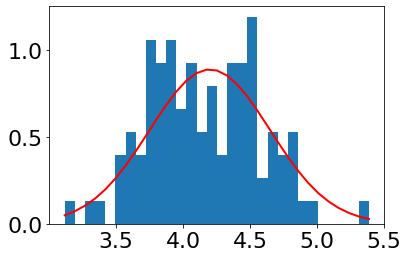

bins =  [3.11680979 3.49521458 3.87361938 4.25202418 4.63042897 5.00883377
 5.38723857]
count =  [ 3. 25. 30. 28. 13.  1.]
BH Masses =  [  1308.60865207   3127.62433851   7475.1408585   17865.87032413
  42700.10806223 102054.87868475 243915.03291233]


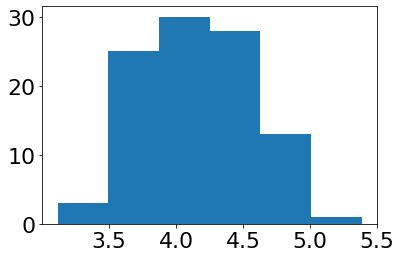

In [4]:
#Ok let's test the model
#First up we need a normal distribution of heavy seed masses
np.random.seed(131182)

#Set up a normal (in log10 space) distribution. Set the mean at 2e4 with a standard deviation of 0.45 ish
mu, sigma = 4.2, 0.45 # mean and standard deviation
#mu, sigma = 4.9, 0.35 # mean and standard deviation
s = np.random.normal(mu, sigma, 100)


masses = np.power(10, s)
#print("masses = ", masses)
print("masses.sum = %e Msolar" % (masses.sum()))
count, bins, ignored = plt.hist(s, 30, density=True)

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')

plt.show()

#To do this I recreate the above histogram without normalising
#and I divide into 5 bins
count, bins, ignored = plt.hist(s, 6, density=False)



print("bins = ", bins)
print("count = ", count)
print("BH Masses = ", np.power(10.0, bins))

In [5]:
#Now calculate the dynamical friction time for each mass bin
#
massbins = np.power(10, bins[1::])
DyTime = []
print("bins = ", massbins)
for M_BH, N_tot in zip(massbins, count):
    M_BH = YTQuantity(M_BH, 'Msun')
    print("M_BH = ", M_BH)
    t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(3e6, 'Msun/kpc**3')/background_density * \
    YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')
    print("t_df = ", t_df)
    print("")
    DyTime.append(t_df)
    
 

bins =  [  3127.62433851   7475.1408585   17865.87032413  42700.10806223
 102054.87868475 243915.03291233]
M_BH =  3127.624338514315 Msun
t_df =  76.36786080235797 Gyr

M_BH =  7475.140858504488 Msun
t_df =  31.952572486174336 Gyr

M_BH =  17865.870324127973 Msun
t_df =  13.369064914971407 Gyr

M_BH =  42700.10806223319 Msun
t_df =  5.593662193491799 Gyr

M_BH =  102054.87868475202 Msun
t_df =  2.3404072711069186 Gyr

M_BH =  243915.0329123253 Msun
t_df =  0.9792343558077546 Gyr



In [6]:
#Calculate the number of mergers for each mass bin in a hubble time
Epsilon = []
for M_BH, Num_HeavySeeds, t_df in zip(massbins, count, DyTime):
    new_radius = NewRadius(R_0, tau_hubble, t_df)
    N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

    #print("N_tot number density = ", N_tot)
    
    #print("Ntot in Galaxy = ", N_tot*np.power(new_radius, 3.0))
    print("Merger Rate = ", MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot).to("Gyr**-1"))

    N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot) * tau_hubble
    

    #Total number of mergers in a Hubble Time
    print("Total Number of Mergers in a Hubble Time = ", N_mm)
    N_mm =  min(Num_HeavySeeds, N_mm)
    epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))
    Epsilon.append(epsilon)
    print("epsilon = ", epsilon)
    print("")

Merger Rate =  7.64660886543038e-05 1/Gyr
Total Number of Mergers in a Hubble Time =  0.0031656960702881754 dimensionless
epsilon =  0.9989447679765706 dimensionless

Merger Rate =  0.005305546757141376 1/Gyr
Total Number of Mergers in a Hubble Time =  1.8304136312137735 dimensionless
epsilon =  0.9267834547514491 dimensionless

Merger Rate =  0.08949728922719584 1/Gyr
Total Number of Mergers in a Hubble Time =  37.05187774005906 dimensionless
epsilon =  1.1102230246251565e-16 dimensionless

Merger Rate =  4.105570866168746 1/Gyr
Total Number of Mergers in a Hubble Time =  1586.3925826876023 dimensionless
epsilon =  -2.220446049250313e-16 dimensionless

Merger Rate =  1866.286392583279 1/Gyr
Total Number of Mergers in a Hubble Time =  334811.77882944007 dimensionless
epsilon =  0.0 dimensionless

Merger Rate =  179148338.18829045 1/Gyr
Total Number of Mergers in a Hubble Time =  2472247066.998407 dimensionless
epsilon =  0.0 dimensionless



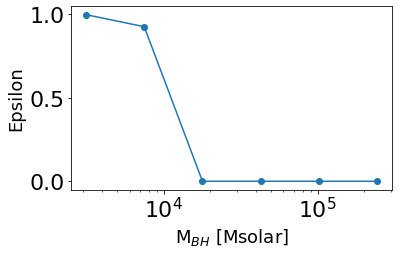

In [7]:
#Now plot the
#1. #Number of black holes at the start in each bin
#2. Overplot the number of black holes at the end

#Plot Epsilon against M_BH
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 18}

#matplotlib.rc('font', **font)
plt.rcParams.update({'font.size': 22})
plt.figure()
plt.semilogx(massbins, Epsilon, marker="o")
plt.xlabel("M$_{BH}$ [Msolar]", fontsize="18")
plt.ylabel("Epsilon", fontsize="18")
plt.tight_layout()
plt.savefig("EpsilonVsMass.pdf")

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/regan/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/l

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.loca

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/l

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/s

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/l

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/s

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/l

/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in multiply
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/home/regan/.local/lib

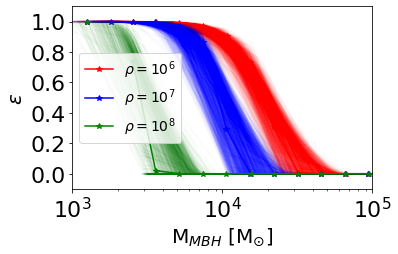

In [8]:
NUMBINS = 20
BinMasses = np.logspace(3, 6, NUMBINS)
np.random.seed(1311805)
TotalMassDensity = 1e8  #Msolar/kpc^3 - above this density we enter the GC region and hence LeoI must be below this!
    
def delta_bin(m, e):
    for i in range(NUMBINS-1):
        if(m > BinMasses[i] and m < BinMasses[i+1]):
            if(e < 0.0):
                continue
            Binned_Mass[i].append(int(m))
            Binned_Epsilon[i].append(e)
plt.figure()
prefactor = [1e-2, 1e-1, 1e0]
eta = 1.0 #DynamicalFrictionEfficiency
linecolors = ['red', 'blue', 'green']
meancolors = ['black', 'black', 'black']
labels = ['$\\rho = 10^6$', '$\\rho = 10^7$', '$\\rho = 10^8$']
for pf, color, color_mean, label in zip(prefactor, linecolors, meancolors, labels):
    background_density = YTQuantity(pf*TotalMassDensity*eta, 'Msun/kpc**3')
    #Ok let's run a MC simulation
    #First up we need a normal distribution of heavy seed masses
    
    Binned_Mass = {}
    Binned_Epsilon = {}
    for i in range(NUMBINS):
        Binned_Mass[i] = []
        Binned_Epsilon[i] = []
    for i in range(1500):
        #Set up a normal (in log10 space) distribution. Set the mean at 2e4 with a standard deviation of 0.45 ish
        mu, sigma = 4.2, 0.45 # mean and standard deviation
        #mu, sigma = 4.9, 0.35 # mean and standard deviation
        s = np.random.normal(mu, sigma, 100)


        masses = np.power(10, s)
   
        #To do this I recreate the above histogram without normalising
        #and I divide into 6 bins
        count, bins, ignored = plt.hist(s, 6, density=False)
  
        massbins = np.power(10, bins[1::])
        DyTime = []
        Epsilon = []
        Masses = []

        for M_BH, Num_HeavySeeds in zip(massbins, count):
            M_BH = YTQuantity(M_BH, 'Msun')
        
            t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(3e6, 'Msun/kpc**3')/background_density * \
            YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')
        
            DyTime.append(t_df)
            new_radius = NewRadius(R_0, tau_hubble, t_df)
            N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

            N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot) * tau_hubble
    

            #Total number of mergers in a Hubble Time
            #print("Total Number of Mergers in a Hubble Time = ", N_mm)
            N_mm =  min(Num_HeavySeeds, N_mm)
            epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))
            Epsilon.append(epsilon.v)
        
            delta_bin(M_BH.v, epsilon.v)
 
        plt.semilogx(massbins, Epsilon, color=color, alpha=0.025)
        
    FinalM = []
    FinalE = []
    for i in range(NUMBINS):
        FinalM.append(np.mean(np.asarray(Binned_Mass[i])))
        FinalE.append(np.mean(np.asarray(Binned_Epsilon[i])))
    #print("FinalM = ", FinalM)
    #print("FinalE = ", FinalE)
    plt.semilogx(FinalM, FinalE, marker="*", color=color, label=label)
    plt.legend(loc='best', fontsize=14)
plt.xlabel("M$_{MBH}$ [M$_{\odot}$]", fontsize="20")
plt.ylabel("$\epsilon$", fontsize="20")
plt.xlim(1e3, 1e5)
plt.ylim(-0.1,1.1)
plt.yticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0))
plt.xticks((1e3, 1e4, 1e5))
plt.tight_layout()
plt.savefig("EpsilonVsMass_MC.pdf")

